In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

In [28]:
def true_solution(x):  
    return x**2 + 5*x + 3

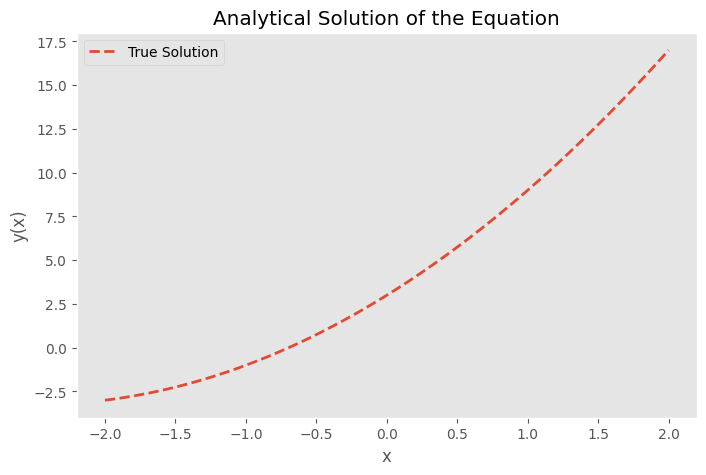

In [29]:
x_test = torch.linspace(-2, 2, 100).view(-1, 1) # 生成测试点  
y_true = true_solution(x_test)  
plt.figure(figsize=(8, 5))  
plt.plot(             # 绘制微分方程的精确解  
    x_test,          
    y_true,   
    linestyle="dashed" ,      
    linewidth=2,   
    label="True Solution"  
)  
  
plt.xlabel("x")  
plt.ylabel("y(x)")  
plt.legend()  
plt.title("Analytical Solution of the Equation")  
plt.grid()  
plt.show()

In [30]:
class PINN(nn.Module):  
    def __init__(self):  
        super(PINN, self).__init__()  
        self.net = nn.Sequential(  
            nn.Linear(1, 20), 
            nn.Tanh(),  
            nn.Linear(20, 20), 
            nn.Tanh(),  
            nn.Linear(20, 1)  
        )  
      
    def forward(self, x):  
        return self.net(x)  
  
model = PINN()  
optimizer = optim.Adam(model.parameters(), lr=1e-3)  
summary(model)

Layer (type:depth-idx)                   Param #
PINN                                     --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       40
│    └─Tanh: 2-2                         --
│    └─Linear: 2-3                       420
│    └─Tanh: 2-4                         --
│    └─Linear: 2-5                       21
Total params: 481
Trainable params: 481
Non-trainable params: 0

In [31]:
def pinn_loss(model, x):  
    x.requires_grad = True  
    y = model(x)  
  
    # 使用自动微分计算dy/dx  
    dy_dx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]  
  
    # 微分方程损失(L_D): dy/dx - (2x + 5)  
    ode_loss = torch.mean((dy_dx - (2*x + 5))**2)  
  
    # 初始条件损失(L_B): y(0) = 3  
    x0 = torch.tensor([[0.0]])  
    y0_pred = model(x0)  
    initial_loss = (y0_pred - 3)**2  
  
    # 总损失  
    total_loss = ode_loss + initial_loss  
    return total_loss, ode_loss, initial_loss

In [32]:
epochs = 10000  
  
loss_history = []  
ode_loss_history = []  
initial_loss_history = []  
  
x_train = torch.linspace(-2, 2, 100).view(-1, 1)  # 训练点  
  
for epoch in range(epochs):  
    optimizer.zero_grad()  
    total_loss, ode_loss, initial_loss = pinn_loss(model, x_train)  
    total_loss.backward()  
    optimizer.step()  
      
    loss_history.append(total_loss.item())  
    ode_loss_history.append(ode_loss.item())  
    initial_loss_history.append(initial_loss.item())  
  
    if epoch % 1000 == 0:  
        print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")

Epoch 0, Loss: 40.137939
Epoch 1000, Loss: 0.535781
Epoch 2000, Loss: 0.004825
Epoch 3000, Loss: 0.000933
Epoch 4000, Loss: 0.000449
Epoch 5000, Loss: 0.000261
Epoch 6000, Loss: 0.000154
Epoch 7000, Loss: 0.000140
Epoch 8000, Loss: 0.000060
Epoch 9000, Loss: 0.000040


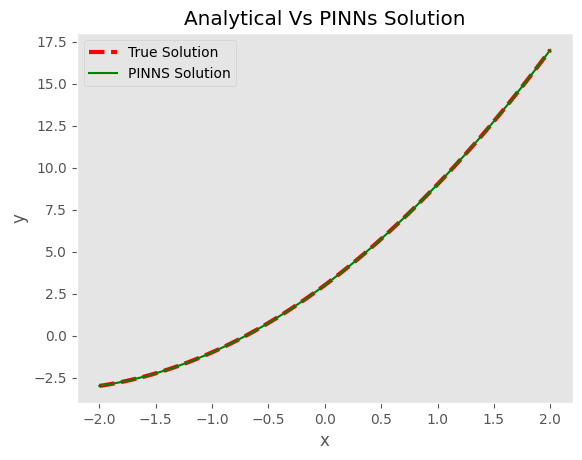

In [33]:
X_test = torch.linspace(-2, 2, 100).view(-1, 1)  
y_pred = model(X_test).detach().numpy()  
  
plt.plot(X_test,true_solution(X_test),linestyle="dashed",linewidth=3,label="True Solution",color="red")  
plt.plot(X_test,y_pred,label="PINNS Solution",color="green")  
plt.xlabel('x')  
plt.ylabel('y')  
plt.legend()  
plt.title(r'Analytical Vs PINNs Solution')  
plt.savefig("solution.png", dpi=300, bbox_inches='tight')  
plt.grid()  
plt.show()

In [ ]:
#https://avoid.overfit.cn/post/f9bd046772f1473a80002f592e9527d4